In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import time

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
model_handle =  ModelHandler("PBHM-HLSTM",
                           r"rst\PBHM-HLSTM",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          )

## load model and data

In [4]:
# define fold/year to evaluate
n_fold = 4
year   = 2013 + n_fold # year 2017

# load datamodel
dm = DataModelCV(DATA_PATH,
       target_name       = model_handle.target_name,
       hincast_features  = model_handle.feat_hindcast,
       forecast_features = model_handle.feat_forecast,
     )

# load trial data
with open(os.path.join(model_handle.hp_path, "trial.json")) as f:
    trial = json.load(f)

hindcast_length = trial['hyperparameters']['values']['hindcast_length']

dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

# load dataset
X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

# load model
tf.keras.backend.clear_session()
keras_save_file_path = os.path.join(model_handle.hp_path, f"model_fold_{n_fold:d}.keras")
model  = tf.keras.models.load_model(keras_save_file_path,
                               custom_objects={'peak_loss'    : loss_peak_mse,  # dummy as no costum functions are saved by keras
                                              'loss_nkge_nnse': loss_peak_mse}) # 

# get baseline input
X_base = tf.zeros_like(X[0])


dictonary loaded


## calculation of Integrated Gradients (ig)

In [ ]:
m = 1 # number of lamellas to approximate integral, m=200 recommended - m=1 for testing

num_samples = y.shape[0]

all_intgrad_0 = np.zeros((num_samples, 96, 5))
all_intgrad_1 = np.zeros((num_samples, 96, 4)) 

time_start = time.time()
time_remain = 1e6
for idx in range(num_samples):

    X_tensor_0 = tf.convert_to_tensor(X[0][[idx],:,:], dtype=tf.float32)
    X_tensor_1 = tf.convert_to_tensor(X[1][[idx],:,:], dtype=tf.float32)
    
    
    base_tensor_0 = tf.zeros_like(X_tensor_0)
    base_tensor_1 = tf.zeros_like(X_tensor_1)
    
    offset_tensor_0 = (X_tensor_0 - base_tensor_0) / tf.constant(m, dtype=tf.float32)
    offset_tensor_1 = (X_tensor_1 - base_tensor_1) / tf.constant(m, dtype=tf.float32)
    
    for k in range(1, m+1):
        inp_tensor_0 = X_tensor_0 + tf.constant(k, dtype=tf.float32) * offset_tensor_0
        inp_tensor_1 = X_tensor_1 + tf.constant(k, dtype=tf.float32) * offset_tensor_1
        inp_tensor_list = [inp_tensor_0 , inp_tensor_1]
    
        with tf.GradientTape() as t:
            t.watch(inp_tensor_0)
            t.watch(inp_tensor_1)
            output = tf.math.reduce_sum(model(inp_tensor_list), axis=1) # analysis sum of model output 
        
        grad_0, grad_1 = t.gradient(output, inp_tensor_list)
        
        if k == 1:
            total_grad_0 = grad_0
            total_grad_1 = grad_1
        else:
            total_grad_0 += grad_0
            total_grad_1 += grad_1
    
    all_intgrad_0[idx,:,:] = offset_tensor_0 * total_grad_0
    all_intgrad_1[idx,:,:] = offset_tensor_1 * total_grad_1

    # estiamte remaining time
    if idx%10 == 0:
        time_ellepsed = time.time() - time_start
        time_remain   = (num_samples - (idx+1)) / ((idx+1) / time_ellepsed)
        print(f"{idx} - time remain: {time_remain/3600:6.2f} h", end="\r")
    else:
        print(f"{idx} - time remain: {time_remain/3600:6.2f} h", end="\r")

In [7]:
# save ig results
# np.save(r"src\rst\ig_total_2017_hindcasts.npy", all_intgrad_0)
# np.save(r"src\rst\ig_total_2017_forecasts.npy", all_intgrad_1)

all_intgrad_0 = np.load(r"src\rst\ig_total_2017_hindcasts.npy")
all_intgrad_1 = np.load(r"src\rst\ig_total_2017_forecasts.npy")

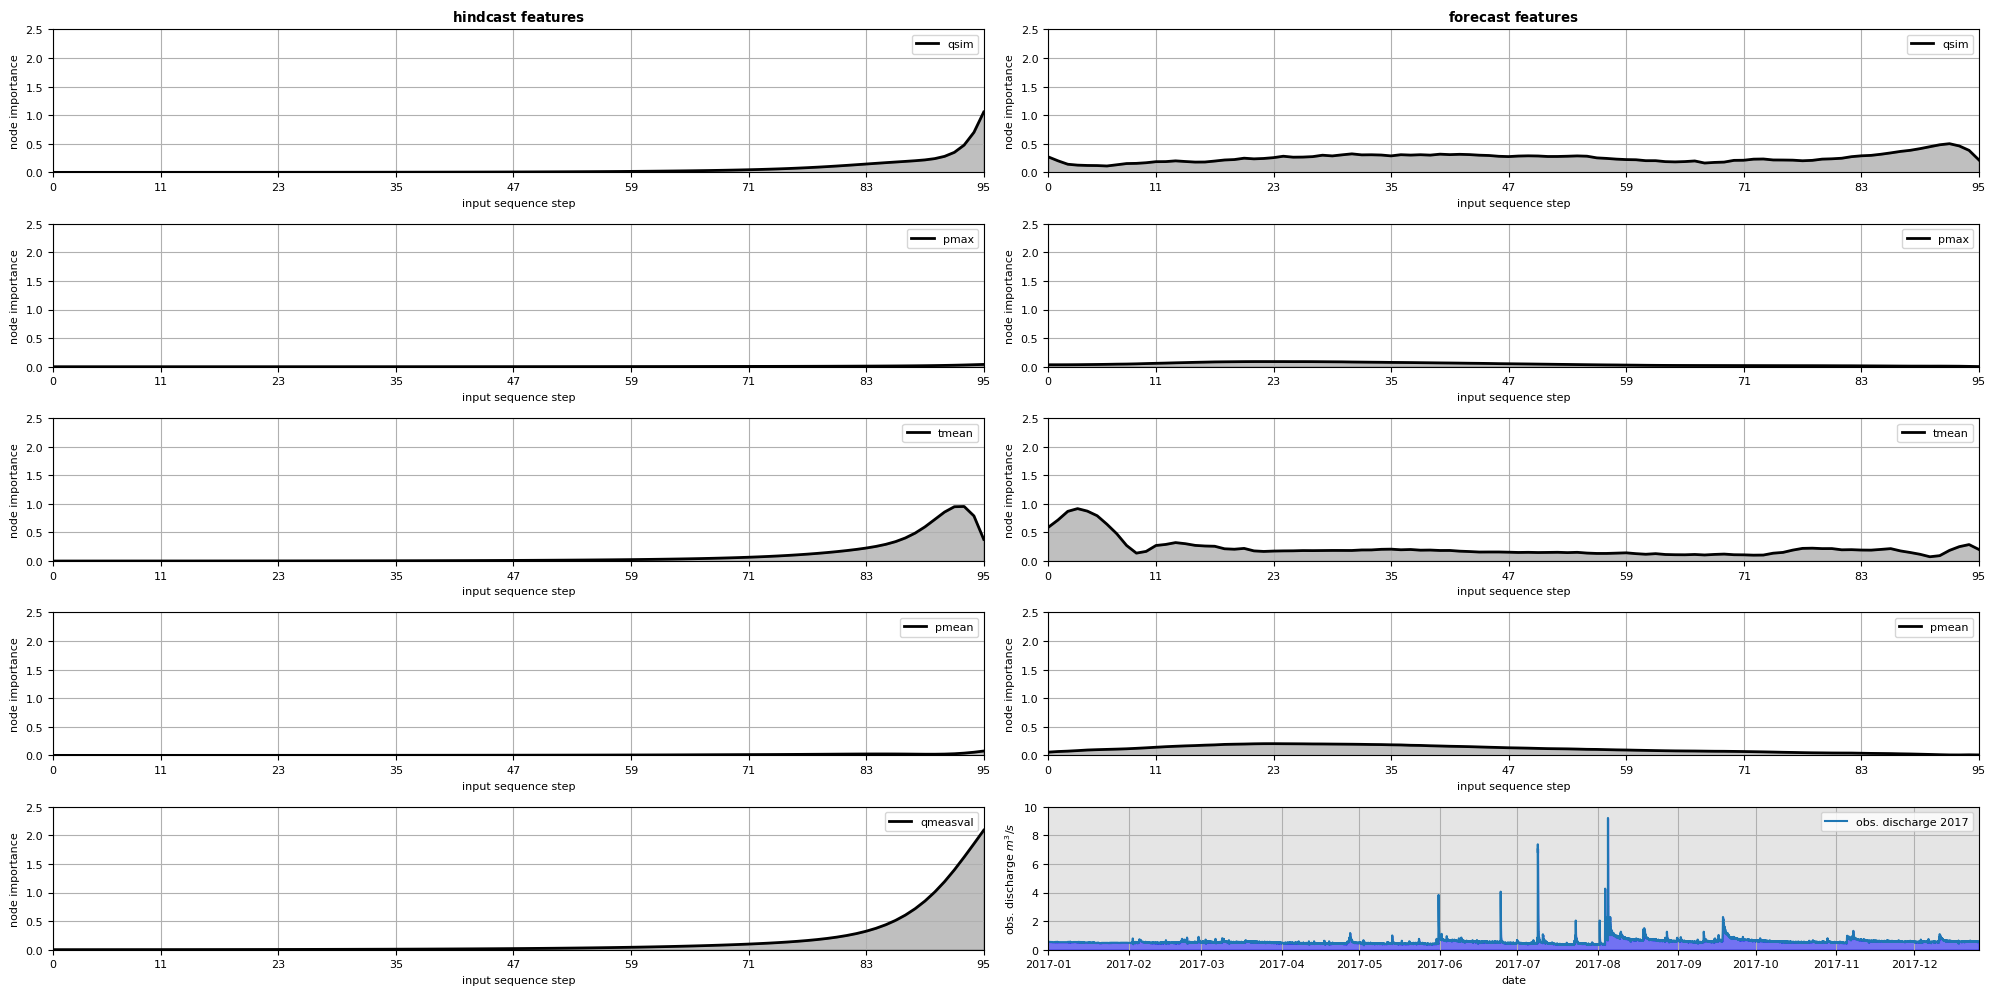

In [8]:
# initalize plot
fig,axes = plt.subplots(5,2, figsize=(20,10))

# plot hindcast features
for n in range(5):
    if n == 0:
        axes[n,0].set_title(r"$\bf{hindcast\ features}$")
    axes[n,0].fill_between(np.arange(96), 
                       np.mean(np.abs(all_intgrad_0[:,:,n]), axis=0),
                       alpha=0.25, color="k")
    axes[n,0].plot(np.mean(np.abs(all_intgrad_0[:,:,n]), axis=0), 
               c="k", lw=2, label=model_handle.feat_hindcast[n])
    axes[n,0].grid(True)
    axes[n,0].set_ylim(0,2.5)
    axes[n,0].set_xlim(0,hindcast_length-1)
    axes[n,0].set_xlabel("input sequence step")
    axes[n,0].set_ylabel("node importance")
    axes[n,0].set_xticks([0] + [x for x in range(11,98,12)])
    axes[n,0].set_yticks([x/2 for x in range(0,6,1)])
    axes[n,0].legend()

# plot forecast features
for n in range(4):
    if n == 0:
        axes[n,1].set_title(r"$\bf{forecast\ features}$")
    axes[n,1].fill_between(np.arange(96), 
                       np.mean(np.abs(all_intgrad_1[:,:,n]), axis=0),
                       alpha=0.25, color="k")
    axes[n,1].plot(np.mean(np.abs(all_intgrad_1[:,:,n]), axis=0), 
               c="k", lw=2, label=model_handle.feat_forecast[n])
    axes[n,1].grid(True)
    axes[n,1].set_ylim(0,2.5)
    axes[n,1].set_xlim(0,95)
    axes[n,1].set_xlabel("input sequence step")
    axes[n,1].set_ylabel("node importance")
    axes[n,1].set_xticks([0] + [x for x in range(11,98,12)])
    axes[n,1].set_yticks([x/2 for x in range(0,6,1)])
    axes[n,1].legend()

# plot observed discharge
dt_indices = dm.getTimeSet(n_fold + 2)[0]

axes[4,1].plot(dt_indices, y[:,0,0], label="obs. discharge 2017")
axes[4,1].fill_between(dt_indices, y[:,0,0],color="b", alpha=0.5)
axes[4,1].set_xlim(mdates.num2date(mdates.datestr2num("2017-1-1")), dt_indices[-1])
axes[4,1].set_ylim(0,10)
axes[4,1].grid()
axes[4,1].legend()
axes[4,1].set_xlabel("date")
axes[4,1].set_ylabel(r"obs. discharge $m^3/s$")
axes[4,1].set_facecolor((0, 0, 0, 0.1))

fig.tight_layout()

In [9]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_all_2017.png"), bbox_inches="tight")

## summary of hindcast features - all 2017

In [10]:
# calculate sums over all hindcast features
np.sum(np.mean(np.abs(all_intgrad_0), axis=0), axis=0)

array([ 5.9438326 ,  0.45226485,  9.58414586,  0.8533452 , 16.40203222])

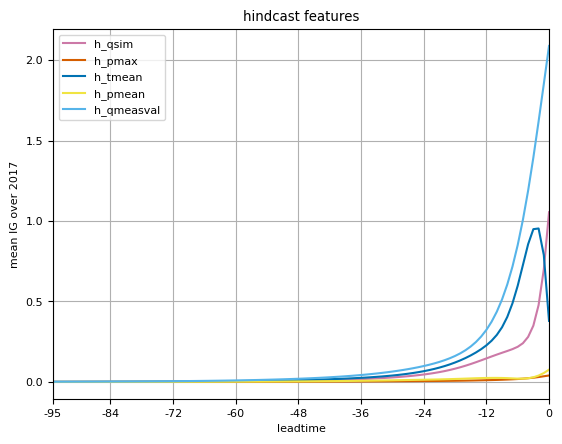

In [11]:
# plot summary for hindcast features
colors  = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]
columns = model_handle.feat_hindcast

# plot
fig, ax = plt.subplots(1,1)
for n in range(5): # sum absolute gradients at input neuron
    ax.plot(np.mean(np.abs(all_intgrad_0), axis=0)[:,n], c=colors[n], label="h_" + columns[n])

ax.set_title("hindcast features")
ax.set_xlabel("leadtime")
ax.set_ylabel("mean IG over 2017")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(-96+x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([0,95])
plt.legend()
plt.grid()


In [12]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_all_2017-hindcast_summary.png"), bbox_inches="tight")

## summary of forecast features - all 2017

In [13]:
# calculate sums over all forecast features
np.sum(np.mean(np.abs(all_intgrad_1), axis=0), axis=0)

array([24.5996654 ,  4.34181497, 21.44317308, 10.76166797])

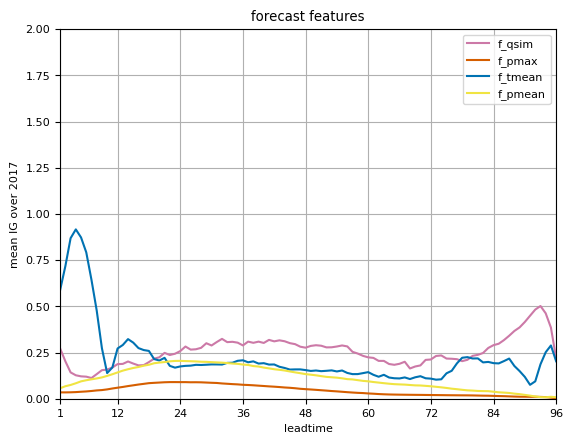

In [16]:
colors  = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]
columns = model_handle.feat_forecast

fig, ax = plt.subplots(1,1)
for n in range(4):
    ax.plot(np.mean(np.abs(all_intgrad_1), axis=0)[:,n], c=colors[n], label="f_" + columns[n])
    
#ax = df[[x for x in df.columns if x[0] == "f"]].plot()
ax.set_title("forecast features")
ax.set_xlabel("leadtime")
ax.set_ylabel("mean IG over 2017")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([0,95])
ax.set_ylim([0,2])
plt.legend()
plt.grid()


In [17]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_all_2017-forecast_summary.png"), bbox_inches="tight")